In [429]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import math
from collections import OrderedDict
from tqdm import tqdm

In [430]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [431]:
import sys
sys.path.insert(0, '../models/')
from model_v1 import *
sys.path.pop(0)
from simplebool_data_gen import *

In [432]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Gen

In [433]:
# Checks if all the values of the two tensors are close together, using torch.isclose()

def checkTensorClose(tensor1, tensor2, atol):
    val_close = torch.sum(torch.isclose(tensor1, tensor2, atol=atol))
    bool_val = torch.sum(val_close) == torch.numel(tensor1)
    return bool_val.item()

In [434]:
# This allows you to look into trainloader and the data returned.

trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=64)
i1, l1 = next(iter(trainloader))
print(torch.max(X_train))
print(torch.min(X_train))
print(torch.max(y_train))
print(torch.min(y_train))

tensor(1.3252)
tensor(-1.3236)
tensor(1.)
tensor(0.)


In [435]:
# Normalized training data from get_train_data()
X_train, y_train = get_train_data([5000, 5000])

X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).view(-1, 1).float()

train_data = []
for i in range(len(X_train)):
    train_data.append([X_train[i], y_train[i]])

print(cache["X_train_mean"])

[2.48437679 2.50353429]


[[1.6382225  0.16131946 0.        ]
 [1.5332781  0.42066762 0.        ]
 [2.490436   1.466334   0.        ]
 ...
 [4.917535   4.8960032  1.        ]
 [4.7821016  4.8224688  1.        ]
 [4.743444   4.748983   1.        ]]
tensor([[0.],
        [0.],
        [0.],
        ...,
        [1.],
        [1.],
        [1.]])


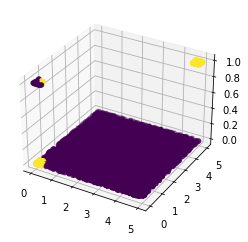

In [436]:
# Plotting the training data, unstandardized
X_train_orig = unstandardize_data(X_train, cache["X_train_mean"], cache["X_train_std"])

print(X_train_orig)
print(y_train)
ax = plt.axes(projection='3d')
ax.scatter3D(X_train_orig[:, 0], X_train_orig[:, 1], y_train, c=X_train[:,2])
# plt.xlim(0,1)
# plt.ylim(0,1)
# Purple is boolean = 0, yellow is boolean = 1

## Model

In [437]:
def get_num_correct(labels, preds):
    preds = get_pred_class(preds)
    return (labels == preds).float().sum()

In [438]:
def get_pred_class(preds):
    return (preds > 0.5).float()

In [439]:
emb_dims = [2,4]

# Always keep batch size in powers of 2, trainloader works faster this way.
batch_size = 256
trainloader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=batch_size)
num_batches = math.ceil(1.0 * len(train_data) / batch_size)

In [440]:
model = WangNet(emb_dims=emb_dims, no_of_cont=2, lin_layer_sizes=[8, 16, 8, 4], \
                output_size=1, hidden_drop_p=0, batch_flag=False)

n_epochs = 100
loss_values = []
acc_values = []
norm_values = []
test_splitA_values = []
test_splitB_values = []

pos_weight = torch.FloatTensor([np.count_nonzero(y_train==0), np.count_nonzero(y_train==1)])/len(y_train)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.9)

# Let's look at how the model does on test split A, during training.
X_testA, X_testA_orig, y_testA = get_test_splitA(1000)
X_testA = torch.tensor(X_testA).float()
y_testA = torch.tensor(y_testA).view(-1, 1).float()

# Let's look at how the model does on test split B, during training.
X_testB, X_testB_orig, y_testB = get_test_splitB([500,500])
X_testB = torch.tensor(X_testB).float()
y_testB = torch.tensor(y_testB).view(-1, 1).float()

t = tqdm(range(1, n_epochs+1), miniters=100)
steps = 0

for epoch in t:
    total_loss = 0
    correct = 0
    
    with torch.no_grad():
        predsA = model(X_testA[:,:2].float(), X_testA[:,2].long())
        testA_acc = get_num_correct(y_testA, predsA) / len(X_testA)
        test_splitA_values.append(testA_acc)
        
        predsB = model(X_testB[:,:2].float(), X_testB[:,2].long())
        testB_acc = get_num_correct(y_testB, predsB) / len(X_testB)
        test_splitB_values.append(testB_acc)
        
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        cont_x = inputs[:,:2].float()
        cat_x = inputs[:,2].long()

        optimizer.zero_grad()
        
        preds = model(cont_x, cat_x)

        loss = criterion(preds, labels)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        # scheduler.step()
        correct += get_num_correct(labels, preds)
        
    for name, param in model.named_parameters():
        grad_norm_sum = 0
        if param.requires_grad and param.grad is not None:
            grad = param.grad.view(-1)
            grad_norm_sum += torch.norm(grad).item()
            
    norm_values.append(grad_norm_sum)

    acc = correct/len(train_data)
    t.set_description(f"-----Epoch: {epoch}/{n_epochs}, Loss: {total_loss/num_batches}, Accuracy: {acc}-----")
    loss_values.append(total_loss/num_batches)
    acc_values.append(acc)

-----Epoch: 100/100, Loss: 0.010537331452360377, Accuracy: 0.9955000281333923-----: 100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Text(0, 0.5, 'Training loss')

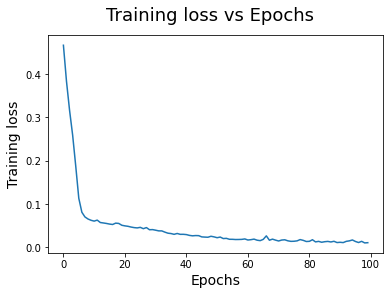

In [441]:
plt.plot(np.array(np.arange(0, n_epochs)), loss_values)
plt.suptitle('Training loss vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training loss', fontsize=14)

Text(0, 0.5, 'Training accuracy')

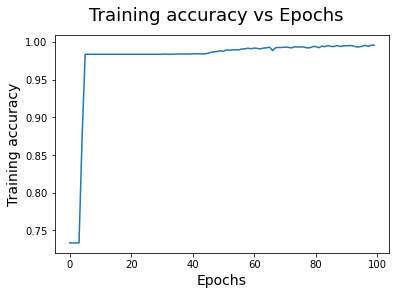

In [442]:
plt.plot(np.array(np.arange(0, n_epochs)), acc_values)
plt.suptitle('Training accuracy vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Training accuracy', fontsize=14)

Text(0, 0.5, 'Sum of gradient norms')

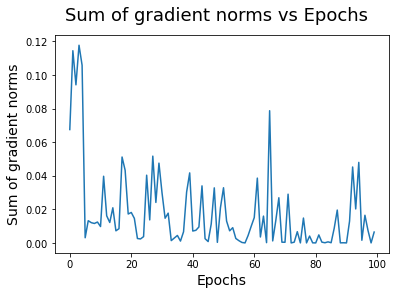

In [443]:
plt.plot(np.array(np.arange(0, n_epochs)), norm_values)
plt.suptitle('Sum of gradient norms vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Sum of gradient norms', fontsize=14)

Text(0, 0.5, 'TestA Accuracy')

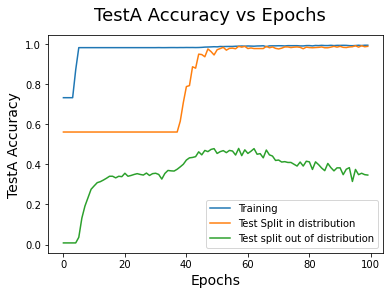

In [444]:
plt.plot(np.array(np.arange(0, n_epochs)), acc_values, label="Training")
plt.plot(np.array(np.arange(0, n_epochs)), test_splitB_values, label="Test Split in distribution")
plt.plot(np.array(np.arange(0, n_epochs)), test_splitA_values, label="Test split out of distribution")
plt.legend()
plt.suptitle('TestA Accuracy vs Epochs', fontsize=18)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('TestA Accuracy', fontsize=14)

Total Accuracy on test split A: 0.3799999952316284


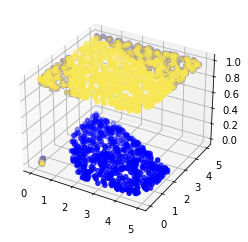

In [445]:
#### Testing Split A
X_testA, X_testA_orig, y_testA = get_test_splitA(1000)

X_testA = torch.tensor(X_testA).float()
y_testA = torch.tensor(y_testA).view(-1, 1).float()

with torch.no_grad():
    predsA = model(X_testA[:,:2].float(), X_testA[:,2].long())
    total_acc = get_num_correct(y_testA, predsA) / len(X_testA)
print(f"Total Accuracy on test split A: {total_acc}")
    
# Comment this line out to see the non-classification predictions.
predsA = get_pred_class(predsA)

# X_testA_orig = unstandardize_data(X_testA, cache["X_testA_mean"], cache["X_testA_std"])
ax = plt.axes(projection='3d')
ax.scatter3D(X_testA_orig[:, 0], X_testA_orig[:, 1], y_testA, c="#F9E755")
ax.scatter3D(X_testA_orig[:, 0], X_testA_orig[:, 1], predsA, c='blue')

Total Accuracy on test split B: 0.9890000224113464


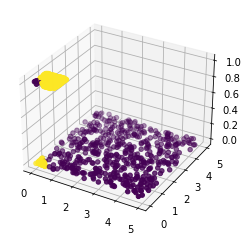

In [446]:
# Testing Split B
X_testB, X_testB_orig, y_testB = get_test_splitB([500,500])

X_testB = torch.tensor(X_testB).float()
y_testB = torch.tensor(y_testB).view(-1, 1).float()

with torch.no_grad():
    predsB = model(X_testB[:,:2].float(), X_testB[:,2].long())
    total_acc = get_num_correct(y_testB, predsB) / len(X_testB)
print(f"Total Accuracy on test split B: {total_acc}")

# # Comment this line out to see the non-classification predictions.
# predsB = get_pred_class(predsB)

B_indices_wrong = (((predsB != y_testB) == True).nonzero(as_tuple=True)[0]).detach().numpy()

# X_testB_orig = unstandardize_data(X_testB, cache["X_testB_mean"], cache["X_testB_std"])
ax = plt.axes(projection='3d')
ax.scatter3D(X_testB_orig[:, 0], X_testB_orig[:, 1], y_testB, c=X_testB[:, 2])
# plt.xlim(0,1)
# plt.ylim(0,1)

tensor([[-36.7279],
        [-12.7080],
        [-23.0179],
        [-25.2909],
        [-36.5703],
        [-34.4845],
        [-33.2958],
        [-31.0201],
        [-34.4987],
        [-31.7615],
        [-36.1592],
        [-32.4704],
        [-38.3276],
        [-35.5123],
        [-35.0564],
        [-38.0397],
        [-38.5768],
        [-34.6695],
        [-27.3570],
        [-35.5066],
        [-24.5444],
        [-37.8157],
        [-25.1844],
        [-19.5981],
        [-23.1798],
        [-35.3214],
        [-21.3747],
        [-34.8464],
        [-33.2178],
        [-38.7352],
        [-34.7509],
        [-35.4918],
        [-33.6395],
        [-36.5474],
        [-33.4483],
        [-29.8669],
        [-14.6393],
        [-38.5436],
        [-35.4771],
        [-30.4963],
        [-36.0606],
        [-30.1440],
        [-34.3202],
        [-36.8043],
        [-16.7217],
        [-26.9691],
        [-35.6712],
        [-21.2861],
        [-35.5615],
        [-33.9311],


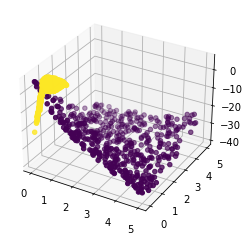

In [447]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_testB_orig[:, 0], X_testB_orig[:, 1], predsB, c=X_testB[:, 2])
print(predsB)
# plt.xlim(0,1)
# plt.ylim(0,1)

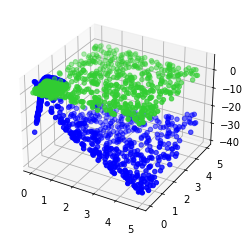

In [448]:
ax = plt.axes(projection='3d')
X_wrong = X_testB_orig[B_indices_wrong]
y_wrong = y_testB[B_indices_wrong]
ax.scatter3D(X_wrong[:, 0], X_wrong[:, 1], y_wrong, c='limegreen')
ax.scatter3D(X_wrong[:, 0], X_wrong[:, 1], predsB[B_indices_wrong], c='blue')

Total Accuracy on test split C: 0.9729999899864197


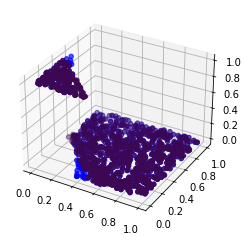

In [449]:
# Testing Split C
X_testC, X_testC_orig, y_testC = get_test_splitC(1000)

# X_testC_orig = unnormalize_data(X_testC, cache["X_testC_mean"], cache["X_testC_std"])

X_testC = torch.tensor(X_testC).float()
y_testC = torch.tensor(y_testC).view(-1, 1).float()

with torch.no_grad():
    predsC = model(X_testC[:,:2].float(), X_testC[:,2].long())
    total_acc = get_num_correct(y_testC, predsC) / len(X_testC)
    
# Comment this line out to see the non-classification predictions.
predsC = get_pred_class(predsC)

print(f"Total Accuracy on test split C: {total_acc}")

# X_testC_orig = unstandardize_data(X_testC, cache["X_testC_mean"], cache["X_testC_std"])

ax = plt.axes(projection='3d')
ax.scatter3D(X_testC_orig[:, 0], X_testC_orig[:, 1], y_testC, c="#3E0851")
ax.scatter3D(X_testC_orig[:, 0], X_testC_orig[:, 1], predsC, c='blue')

In [450]:
cache

{'X_train_mean': array([2.48437679, 2.50353429]),
 'X_train_std': array([1.93945645, 1.94764514]),
 'X_testA_mean': array([2.51631106, 2.58116991]),
 'X_testA_std': array([1.46694814, 1.43486284]),
 'X_testB_mean': array([1.50315714, 1.47411389]),
 'X_testB_std': array([1.42317139, 1.43047499]),
 'X_testC_mean': array([0.4889003 , 0.47975785]),
 'X_testC_std': array([0.28831799, 0.28710965])}

In [451]:
get_test_splitC(1000)

(array([[-1.07973458, -1.09535224,  0.        ],
        [-1.26963384, -1.16800383,  0.        ],
        [-1.12545699, -1.0591238 ,  0.        ],
        ...,
        [-0.8300325 , -1.17634465,  0.        ],
        [-0.78149455, -1.25624214,  0.        ],
        [-1.23348993, -0.98715388,  0.        ]]),
 array([[0.39027859, 0.37017682, 0.        ],
        [0.02197724, 0.22867731, 0.        ],
        [0.30160196, 0.44073697, 0.        ],
        ...,
        [0.87456489, 0.21243236, 0.        ],
        [0.96870215, 0.05682039, 0.        ],
        [0.09207679, 0.58090884, 0.        ]]),
 array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.,
        0., 0., 0., 